# 添加工具

为了处理聊天机器人无法“凭记忆”回答的查询，请集成一个网页搜索工具。聊天机器人可以使用此工具查找相关信息并提供更好的回复。

> 本教程基于[构建一个基本聊天机器人](/1-Base.ipynb)。

##### 先决条件

在开始本教程之前，请确保您具备以下条件：

- [Tavily 搜索引擎](https://python.langchain.ac.cn/docs/integrations/tools/tavily_search/)的 API 密钥。

***使用github / Google账号登陆之后每个人都有免费额度，直接使用APIKEY即可***

##### 1.安装搜索引擎

安装使用Tavily 搜索引擎所需的依赖。

In [1]:
pip install -U langchain-tavily

Note: you may need to restart the kernel to use updated packages.


##### 2.定义工具

定义网页搜索工具

*API参考：[TavilySearch](https://python.langchain.ac.cn/api_reference/tavily/tavily_search/langchain_tavily.tavily_search.TavilySearch.html)*

In [2]:
from dotenv import load_dotenv

load_dotenv()

from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What is the capital of France?")

{'query': 'What is the capital of France?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://en.wikipedia.org/wiki/Paris',
   'title': 'Paris - Wikipedia',
   'content': 'Paris is the capital and largest city of France. With an estimated population of 2,048,472 in January 2025 in an area of more than 105 km2 (41 sq mi),',
   'score': 0.86024034,
   'raw_content': None},
  {'url': 'https://home.adelphi.edu/~ca19535/page%204.html',
   'title': 'Paris facts: the capital of France in history',
   'content': 'Paris, France   ## Paris facts: Paris, the **capital of France** Paris is the **capital of France**, Paris has 2.234 million inhabitants ## Paris facts: Paris history Republic, Paris has a rich 2000 year history. See details of Paris churches, including Notre ## Paris facts: Paris, a world city Paris is a world capital city of shopping french fashion brands. All of this turns Paris into a ## Paris facts: the capital of France in history Before

##### 3.定义图谱

对于您在[第一个教程](/1-Base.ipynb)中创建的`StateGraph`，在 LLM 上添加`bind_tools`。这让 LLM 知道如果要使用搜索引擎，应使用正确的 JSON 格式。

我们首先选择我们的 LLM

In [4]:
from dotenv import load_dotenv
import os

load_dotenv()
DEEPSEEK_API_KEY = os.getenv("DEEPSEEK_API_KEY") 

if DEEPSEEK_API_KEY:
    print("DEEPSEEK_API_KEY is set")
else:
    print("DEEPSEEK_API_KEY is not set")

from langchain_deepseek import ChatDeepSeek

llm = ChatDeepSeek(api_key=DEEPSEEK_API_KEY, model="deepseek-chat")

DEEPSEEK_API_KEY is set


我们现在可以将其整合到`StateGraph`中。

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

##### 4.创建运行工具的函数

现在，创建一个函数来运行被调用的工具。通过将工具添加到一个名为`BasicToolNode`的新节点来完成，该节点检查状态中的最新消息，如果消息包含`tool_calls`，则调用工具。它依赖于 LLM 的`tool_calling`支持，该支持在 Anthropic、OpenAI、Google Gemini 和许多其他 LLM 提供商中可用。

*API 参考：[ToolMessage](https://python.langchain.ac.cn/api_reference/core/messages/langchain_core.messages.tool.ToolMessage.html)*

In [6]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

> 如果您将来不想自己构建此功能，可以使用 LangGraph 的预构建[ToolNode](https://github.langchain.ac.cn/langgraph/reference/agents/#langgraph.prebuilt.tool_node.ToolNode)。

In [ ]:
'''
使用预购建的ToolNode的方式：
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)
'''

##### 5.定义`conditional_edges`

添加工具节点后，现在可以定义`conditional_edges`。

**边 (Edges)** 将控制流从一个节点路由到下一个节点。**条件边 (Conditional edges)** 从一个节点开始，通常包含“if”语句，根据当前的图谱状态路由到不同的节点。这些函数接收当前的图谱state并返回一个字符串或字符串列表，指示接下来要调用哪个（或哪些）节点。

接下来，定义一个名为`route_tools`的路由函数，它检查聊天机器人输出中的`tool_calls`。通过调用`add_conditional_edges`将此函数提供给图谱，这告诉图谱每当`chatbot`节点完成时，就检查此函数以确定接下来去哪里。

如果存在工具调用，条件将路由到`tools`；如果不存在，则路由到`END`。由于条件可以返回`END`，因此这次您无需显式设置`finish_point`。

In [8]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

##### 6.可视化图谱（可选）

您可以使用`get_graph`方法和其中一种“draw”方法（如`draw_ascii`或`draw_png`）来可视化图谱。每种`draw`方法都需要额外的依赖。

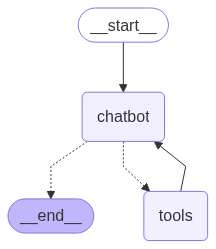

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

##### 7.向机器人提问

现在您可以向聊天机器人提出其训练数据之外的问题。

In [11]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: Who is xQc?
Assistant: 
Assistant: {"query": "Who is xQc", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://youtube.fandom.com/wiki/XQc", "title": "xQc - Wikitubia - Fandom", "content": "F\u00e9lix Lengyel (( \"wikipedia:Help:IPA/French\"); born: November 12, 1995 (1995-11-12) [age 29]), better known online as xQc (formerly xQcOW), is a Canadian Twitch streamer, YouTuber and former competitive Overwatch player. F\u00e9lix is known for playing as a tank for Team Canada in the Overwatch World Cup and has also played other games such as League of Legends and StarCraft.\n\n## Contents\n\n## Username[]\n\nF\u00e9lix's username stands for \"F\u00e9lix Quebec Overwatch\". [...] Wikitubia\n\nYou are not currently logged in. You will still be able to browse Wikitubia, but you will be unable to edit without an account. Please go here to create a Fandom account.\n\nREAD MORE\n\nWikitubia\nThis page contains material from Wikipedia\nXQc has more than On

##### 8.使用预购建组件

为了方便使用，调整您的代码以将以下内容替换为 LangGraph 预构建组件。这些组件内置了并行 API 执行等功能。

- BasicToolNode被预构建的[`ToolNode`](https://github.langchain.ac.cn/langgraph/reference/prebuilt/#toolnode)取代。
- route_tools被预构建的[`tools_condition`](https://github.langchain.ac.cn/langgraph/reference/prebuilt/#tools_condition)取代。

In [12]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

**恭喜**！ 您已经在 LangGraph 中创建了一个对话代理，它可以在需要时使用搜索引擎检索更新信息。现在它可以处理更广泛的用户查询。要检查您的代理刚刚执行的所有步骤，请查看此[LangSmith 追踪](https://smith.langchain.com/public/4fbd7636-25af-4638-9587-5a02fdbb0172/r)。

##### 下一步

聊天机器人无法自行记住过去的交互，这限制了其进行连贯的多轮对话的能力。在下一部分中，您将[添加记忆](/3-Memory.ipynb)来解决这个问题。